### Reference: 

https://appliednetsci.springeropen.com/track/pdf/10.1007/s41109-019-0248-7.pdf
    
https://arxiv.org/pdf/1606.02353.pdf

### Import MIP weights file

In [1]:
import numpy as np 

folder_location = './data/'
weight_file_name = 'mip_weight_1000.npy'
weights = np.load(folder_location + weight_file_name)

F = len(weights[0])
C = len(weights[0][1])
weights = weights[0]

### Set $k$ and $\delta$

In [2]:
delta = 0.7
k = 3

### Distance and CkNN functions

In [12]:
# distance metric: 
def distance(p1,p2):
    d = 0
    for c in range(C): 
        if weights[p1][c] != weights[p2][c]: 
            d += 1 
    return d 

# weight between 2 pixels: 
def weight(p1,p2): 
    w = 0 
    for c in range(C): 
        if weights[p1][c] == weights[p2][c]: 
            w += 1 
    return w 

# neighbours of a pixel in descending order of proximity (nearest appears first): 
def neighbours(a): 
    res = []
    for i in range(k): 
        for f in range(F): 
            if f != a and distance(f,a) == i:
                res.append(f)
    return res

In [13]:
all_neighbours = [] 
for f in range(F): 
    all_neighbours.append(neighbours(f))

In [14]:
# compute the RHS of the CkNN inequality: 

from math import sqrt

def cknn(a, b, delta, k):
    rhs = 0 
    a_knn = all_neighbours[a]
    b_knn = all_neighbours[b]
    if len(a_knn) >= k and len(b_knn) >= k: 
        rhs = delta * sqrt(distance(a, a_knn[k-1]) * distance(b, b_knn[k-1]))
    else: 
        rhs = delta * sqrt(C * C)
    return rhs 


### Adjacency matrix

In [15]:
# adjacency matrix based on CkNN: 

adj = [[0 for f1 in range(F)] for f2 in range(F)]
for f1 in range(F): 
    for f2 in range(F):
        if distance(f1,f2) < cknn(f1,f2,delta,k): 
            adj[f1][f2] = 1 

### Remove unimportant pixels

In [16]:
# remove all pixels whose weights are all 0: 
remove = []

for i in range(F): 
    if list(weights[i]) == [0] * C: 
        remove.append(i)

# return pixels that have at least one non-zero weight: 
remain = [i for i in range(F) if i not in remove]

### Edges, edge weights and connected nodes

In [17]:
# return lists of edges, edge weights and connected nodes of the network: 

edges = []
edge_wts = []
connected_nodes = []
for f1 in range(F): 
    
    # find direct neighbours of a pixel (i.e. 8-neighbours): 
    if f1 in list(range(27,784,28)): 
        f1_neighbours = [f1-28, f1-1, f1+28]
    elif f1 in list(range(0,757,28)): 
        f1_neighbours = [f1-28, f1+1, f1+28]
    else: 
        f1_neighbours = [f1-1, f1+1, f1-28, f1-29, f1-27, f1+28, f1+29, f1+27]
    
    # find edges, return scaled edge weights and add relevant pixels to connected nodes: 
    for f2 in range(F): 
        if f2 in f1_neighbours and f1 != f2 and f1 in remain and f2 in remain and adj[f1][f2] == 1:
            if (f1,f2) not in edges and (f2,f1) not in edges: 
                edges.append((f1,f2))
                edge_wts.append(weight(f1,f2)/5)
            if f1 not in connected_nodes: 
                connected_nodes.append(f1)
            if f2 not in connected_nodes: 
                connected_nodes.append(f2)

### Network before coloring based on digits

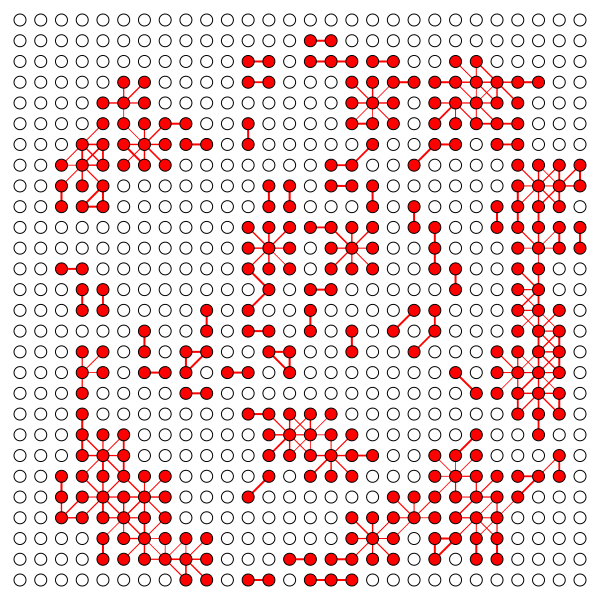

In [18]:
# make connected nodes red: 
colors = [0 for f in range(F)]
for f in range(F): 
    if f in connected_nodes: 
        colors[f] = "red"
    else: 
        colors[f] = "white"
        
import sys
import igraph as ig
from igraph import *
import re
import cairo
import random

random.seed(123)

g = Graph(n = F, edges = edges,
          vertex_attrs={'color': colors})

# vertex attributes: 

visual_style = {}
visual_style["vertex_size"] = 12
#visual_style["vertex_label_size"] = 5
#g.vs["name"] = [str(i) for i in range(F)]
#g.vs["label"] = g.vs["name"]


# edge attributes: 

g.es["width"] = edge_wts
g.es["color"] = "red"


layout = g.layout_grid(width=28, height=0, dim=2)


#ig.plot(g, "./delta_" + str(delta) + "_k_" + str(k) + ".png", layout = layout, **visual_style)
ig.plot(g, layout = layout, **visual_style)

### Colored network based on a specified digit

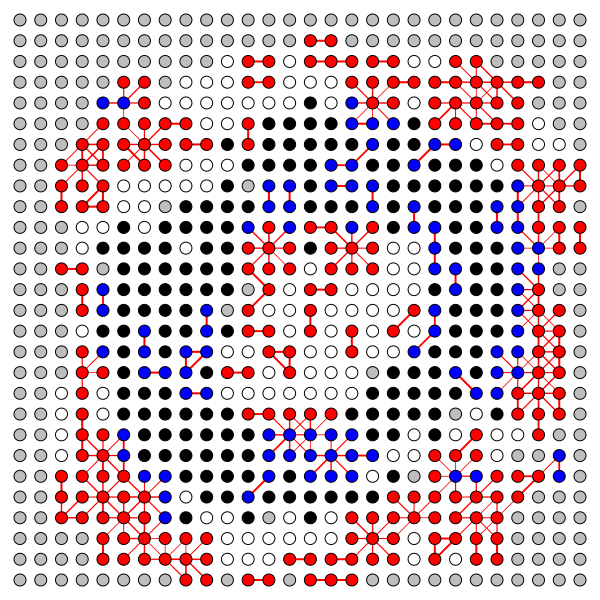

In [16]:
mnist_colors = [[0 for f in range(F)] for c in range(C)]
for f in range(F): 
    for c in range(C):
        if f in connected_nodes:
            if weights[f][c] == 1: 
                mnist_colors[c][f] = "blue"
            else: 
                mnist_colors[c][f] = "red"
        elif weights[f][c] == 1: 
            mnist_colors[c][f] = "black"
        elif weights[f][c] == -1:
            mnist_colors[c][f] = "white"
        else: 
            mnist_colors[c][f] = "gray"

digit = 0
random.seed(123)

g = Graph(n = F, edges = edges,
              vertex_attrs={'color': mnist_colors[digit]})

visual_style = {}
visual_style["vertex_size"] = 12
#visual_style["vertex_label_size"] = 5
#g.vs["name"] = [str(i) for i in range(F)]
#g.vs["label"] = g.vs["name"]

g.es["width"] = edge_wts
g.es["color"] = "red"

    
layout = g.layout_grid(width=28, height=0, dim=2)

#ig.plot(g, "./blue/digit_" + str(digit) + ".png", layout = layout, **visual_style)
ig.plot(g, layout = layout, **visual_style)


### below code generates and saves images of all digits to specified folder: 

In [ ]:
for digit in range(C): 
    random.seed(123)

    g = Graph(n = F, edges = edges,
              vertex_attrs={'color': mnist_colors[digit]})

    visual_style = {}
    visual_style["vertex_size"] = 12
    #visual_style["vertex_label_size"] = 5

    g.es["width"] = edge_wts
    g.es["color"] = "red"
    #g.vs["name"] = [str(i) for i in range(F)]
    #g.vs["label"] = g.vs["name"]

    #layout = g.layout_fruchterman_reingold() # potential

    layout = g.layout_grid(width=28, height=0, dim=2)

    ig.plot(g, "./blue/digit_" + str(digit) + ".png", layout = layout, **visual_style)
    #ig.plot(g, layout = layout, **visual_style)